- ベースライン試算
- EDA

# Library

In [165]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')

In [4]:
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [65]:
# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics

In [7]:
# model
import lightgbm as lgb

# Load data

In [11]:
base_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
base_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# config

In [15]:
y_col = 'Survived'

In [16]:
drop_cols = ['PassengerId']

# Baseline

In [21]:
base_x_cols = drop_cols.copy()
base_x_cols.append(y_col)

In [57]:
base_x = base_df.drop(base_x_cols, axis=1)
base_y = base_df.loc[:, y_col]

In [58]:
for c, t in zip(base_x.columns, base_x.dtypes):
    if t == 'object':
        base_x[c] = base_x[c].astype(str)
        labels = base_x[c]
        if labels.isna().sum() == 0:
            labels.append(None)
        
        le = LabelEncoder()
        le.fit(labels)
        base_x[c] = le.transform(base_x[c])
        
base_x.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,108,1,22.0,1,0,523,7.2500,147,2
1,1,190,0,38.0,1,0,596,71.2833,81,0


## Baseline Result

In [151]:
base_x_train, base_x_test, base_y_train, base_y_test = train_test_split(base_x, base_y, train_size=0.7, random_state=1)

base_model = lgb.LGBMClassifier()
base_model.fit(base_x_train, base_y_train)

# テストデータを予測する
base_y_pred = base_model.predict(base_x_test)

# 精度を計算する
fpr, tpr, thresholds = metrics.roc_curve(base_y_test, base_y_pred)
auc = metrics.auc(fpr, tpr)
print('AUC: %.2f' % auc)

accuracy = metrics.accuracy_score(base_y_test, base_y_pred)
print('Accuracy: %.2f' % accuracy)

precision = metrics.precision_score(base_y_test, base_y_pred)
print('Precision: %.2f' % precision)

recall = metrics.recall_score(base_y_test, base_y_pred)
print('Recall: %.2f' % recall)

f1 = metrics.f1_score(base_y_test, base_y_pred)
print('F1: %.2f' % f1)

AUC: 0.74
Accuracy: 0.76
Precision: 0.78
Recall: 0.61
F1: 0.68


# EDA

In [71]:
base_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Pclass

- 安い客室に泊まっている人たちの生存率が低い

In [79]:
# sns.boxplot(x='Pclass', y=y_col, data=base_df)
base_df.pivot_table(index='Pclass', columns=[y_col], values='Name', aggfunc='count').reset_index()

Survived,Pclass,0,1
0,1,80,136
1,2,97,87
2,3,372,119


## Name

- 名前に身分が入っている
 - 身分ごとに生存率が変わる可能性大

In [152]:
# for n in base_df.Name.unique():
#     print(n)

In [96]:
name_df = base_df['Name'].str.split('.')
sample_name_list = []
for n in name_df:
#     print(n[0].split(' ')[-1])
    sample_name_list.append(n[0].split(' ')[-1])
set(sample_name_list)

{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [99]:
name_eda_df = base_df.copy()
name_eda_df['name_title'] = name_eda_df['Name'].map(lambda x: x.split('.')[0].split(' ')[-1])
name_eda_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name_title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [109]:
name_eda_df.pivot_table(index='name_title', columns=[y_col], values='Name', aggfunc='count').reset_index()

Survived,name_title,0,1
0,Capt,1.0,NaN
1,Col,1.0,1.0
2,Countess,NaN,1.0
3,Don,1.0,NaN
4,Dr,4.0,3.0
5,Jonkheer,1.0,NaN
6,Lady,NaN,1.0
7,Major,1.0,1.0
8,Master,17.0,23.0
9,Miss,55.0,127.0


## Sex

- 女性の方が生存率が高い

In [108]:
base_df.pivot_table(index='Sex', columns=[y_col], values='SibSp', aggfunc='count').reset_index()

Survived,Sex,0,1
0,female,81,233
1,male,468,109


## Age

- 10歳以下の小さい子供は生存率が高い

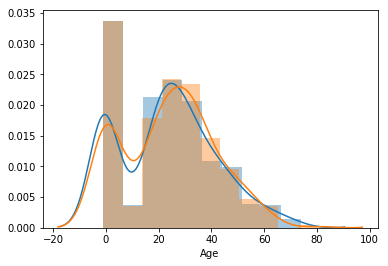

In [223]:
sns.distplot(age_eda_df.query('Survived == 0')['Age'].fillna(-1))
sns.distplot(age_eda_df.query('Survived == 1')['Age'].fillna(-1))
plt.show()

In [226]:
age_bins = list(range(0, 111, 10))
age_bins.append(-10)
age_bins.sort()
age_bins

[-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

In [228]:
age_eda_df = base_df.copy()
age_eda_df['Age'] = age_eda_df['Age'].fillna(-1)
age_eda_df['age_bin'] = pd.cut(age_eda_df['Age'], bins=age_bins)
age_eda_df['age_bin'] = age_eda_df['age_bin'].astype('str')
age_eda_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(20, 30]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(30, 40]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(20, 30]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(30, 40]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(30, 40]"


In [229]:
age_eda_df.pivot_table(index='age_bin', columns = [y_col], values='Age', aggfunc='count').reset_index()

Survived,age_bin,0,1
0,"(-10, 0]",125,52
1,"(0, 10]",26,38
2,"(10, 20]",71,44
3,"(20, 30]",146,84
4,"(30, 40]",86,69
5,"(40, 50]",53,33
6,"(50, 60]",25,17
7,"(60, 70]",13,4
8,"(70, 80]",4,1


(array([227.,  33., 163., 182., 123.,  74.,  50.,  26.,  11.,   2.]),
 array([-1. ,  7.1, 15.2, 23.3, 31.4, 39.5, 47.6, 55.7, 63.8, 71.9, 80. ]),
 <a list of 10 Patch objects>)

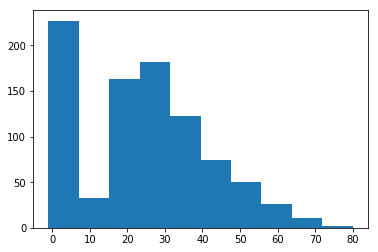

In [230]:
hoge = age_eda_df.copy()
hoge['Age'] = age_eda_df['Age'].fillna(-10)
hoge['Age'] = hoge['Age'].astype(float)
plt.hist(hoge['Age'])
# age_eda_df['Age'].unique()

## SibSp (# of siblings / spouses aboard the Titanic)

- 兄弟or配偶者がいる方が生存確率が高い

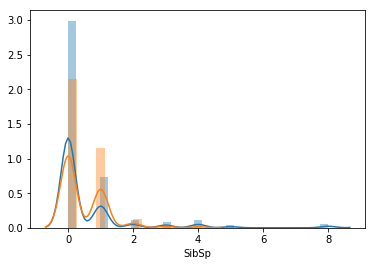

In [113]:
sns.distplot(base_df.query('Survived == 0')['SibSp'])
sns.distplot(base_df.query('Survived == 1')['SibSp'])
plt.show()

In [136]:
base_df.pivot_table(index='SibSp', columns=[y_col], values='Name', aggfunc='count').reset_index()

Survived,SibSp,0,1
0,0,398.0,210.0
1,1,97.0,112.0
2,2,15.0,13.0
3,3,12.0,4.0
4,4,15.0,3.0
5,5,5.0,NaN
6,8,7.0,NaN


## Parch (# of parents / children aboard the Titanic)

- 親か子供が数人いた方が生存率が高い

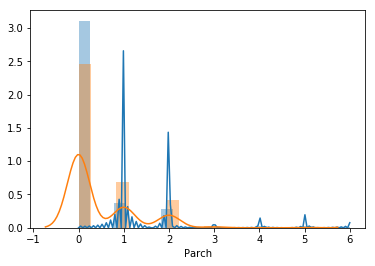

In [145]:
sns.distplot(age_eda_df.query('Survived == 0')['Parch'].fillna(-1))
sns.distplot(age_eda_df.query('Survived == 1')['Parch'].fillna(-1))
plt.show()

In [146]:
base_df.pivot_table(index='Parch', columns=[y_col], values='Name', aggfunc='count').reset_index()

Survived,Parch,0,1
0,0,445.0,233.0
1,1,53.0,65.0
2,2,40.0,40.0
3,3,2.0,3.0
4,4,4.0,NaN
5,5,4.0,1.0
6,6,1.0,NaN


## Ticket

- チケットの文字数が一定の長さ（6文字、8文字）だと生存率が低そう
- チケットにアルファベットが入っているか否かは関係ない

In [190]:
# for n in base_df.Ticket.unique():
#     print(n)

In [159]:
tic_eda_df = base_df.copy()
tic_eda_df['ticket_len'] = tic_eda_df['Ticket'].map(lambda x: len(x.replace(' ', '').replace('.', '').replace(',', '')))

In [176]:
tic_eda_df.pivot_table(index='ticket_len', columns=[y_col], values='Name', aggfunc='count').reset_index()

Survived,ticket_len,0,1
0,3,2.0,NaN
1,4,64.0,37.0
2,5,53.0,82.0
3,6,304.0,140.0
4,7,68.0,55.0
5,8,23.0,10.0
6,9,1.0,2.0
7,10,2.0,NaN
8,12,6.0,5.0
9,13,1.0,1.0


In [168]:
# アルファベットが含まれているか
def is_alphabet_in(s):
    return bool(re.search(r'[a-zA-Z]', s))
tic_eda_df['ticket_contains_str'] = tic_eda_df['Ticket'].map(is_alphabet_in)

In [171]:
hoge = tic_eda_df.pivot_table(index='ticket_contains_str', columns=[y_col], values='Name', aggfunc='count').reset_index()
hoge

Survived,ticket_contains_str,0,1
0,False,407,254
1,True,142,88


In [173]:
hoge['suvive_rate'] = hoge[1] / (hoge[0] + hoge[1])
hoge

Survived,ticket_contains_str,0,1,suvive_rate
0,False,407,254,0.384266
1,True,142,88,0.382609


## Fare

- 賃料が高いほうが生存率が高い

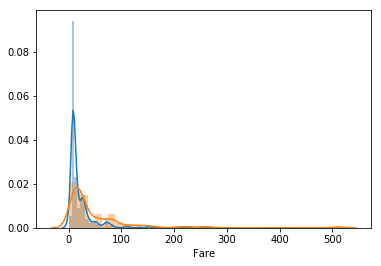

In [177]:
sns.distplot(base_df.query('Survived == 0')['Fare'].fillna(-1))
sns.distplot(base_df.query('Survived == 1')['Fare'].fillna(-1))
plt.show()

In [179]:
fare_bins = list(range(0, 601, 10))
fare_bins.append(-1)
fare_bins.sort()
# fare_bins

In [182]:
fare_eda_df = base_df.copy()
fare_eda_df['fare_bin'] = pd.cut(fare_eda_df['Fare'].fillna(-1), bins=fare_bins)
fare_eda_df['fare_bin'] = fare_eda_df['fare_bin'].astype('str')
fare_eda_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(0, 10]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(70, 80]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(0, 10]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(50, 60]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(0, 10]"


In [189]:
hoge = fare_eda_df.pivot_table(index='fare_bin', columns = [y_col], values='Age', aggfunc='count').reset_index()
hoge['bin_min'] = hoge['fare_bin'].str.split(',')
hoge['bin_min'] = hoge['bin_min'].map(lambda x: int(x[0].replace('(', '')))
hoge['suvive_rate'] = hoge[1] / (hoge[0] + hoge[1])
hoge.sort_values(by='bin_min')

Survived,fare_bin,0,1,bin_min,suvive_rate
0,"(-1, 0]",6.0,1.0,-1,0.142857
1,"(0, 10]",183.0,46.0,0,0.200873
2,"(10, 20]",89.0,66.0,10,0.425806
9,"(20, 30]",65.0,55.0,20,0.458333
14,"(30, 40]",31.0,20.0,30,0.392157
15,"(40, 50]",10.0,4.0,40,0.285714
16,"(50, 60]",9.0,22.0,50,0.709677
18,"(60, 70]",4.0,6.0,60,0.600000
19,"(70, 80]",12.0,18.0,70,0.600000
20,"(80, 90]",3.0,12.0,80,0.800000


## Cabin

- 船室名が長い（≒複数の船室をとっている）方が生存率が高い
- 船室名が不明の人の生存率が著しく低い
- 船室名の頭がB・D・Eの人の生存率が高い

In [192]:
# for n in base_df.Cabin.unique():
#     print(n)

In [201]:
cab_eda_df = base_df.copy()
cab_eda_df['cabin_len'] = cab_eda_df['Cabin'].fillna('').map(lambda x: len(str(x).replace(' ', '').replace('.', '').replace(',', '')))

In [202]:
cab_eda_df.pivot_table(index='cabin_len', columns=[y_col], values='Name', aggfunc='count').reset_index()

Survived,cabin_len,0,1
0,0,481.0,206.0
1,1,2.0,2.0
2,2,7.0,17.0
3,3,41.0,87.0
4,4,11.0,17.0
5,6,4.0,8.0
6,9,3.0,3.0
7,12,NaN,2.0


In [203]:
cab_eda_df['head_cabin'] = cab_eda_df['Cabin'].map(lambda x: str(x)[0])
cab_eda_df.head_cabin.unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [206]:
hoge = cab_eda_df.pivot_table(index='head_cabin', columns=[y_col], values='Name', aggfunc='count').reset_index().fillna(0)
hoge['suvive_rate'] = hoge[1] / (hoge[0] + hoge[1])
hoge

Survived,head_cabin,0,1,suvive_rate
0,A,8.0,7.0,0.466667
1,B,12.0,35.0,0.744681
2,C,24.0,35.0,0.593220
3,D,8.0,25.0,0.757576
4,E,8.0,24.0,0.750000
5,F,5.0,8.0,0.615385
6,G,2.0,2.0,0.500000
7,T,1.0,0.0,0.000000
8,n,481.0,206.0,0.299854


## Embarked

- C(Cherbourg)から乗った人の生存率が高い

In [208]:
# sns.boxplot(x='Pclass', y=y_col, data=base_df)
hoge = base_df.pivot_table(index='Embarked', columns=[y_col], values='Name', aggfunc='count').reset_index()
hoge['suvive_rate'] = hoge[1] / (hoge[0] + hoge[1])
hoge

Survived,Embarked,0,1,suvive_rate
0,C,75,93,0.553571
1,Q,47,30,0.389610
2,S,427,217,0.336957


# Preprocessing Approach

In [209]:
base_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

- 'Pclass':
 - 何もしない
- 'Name':
 - 名前に入っている身分を特徴量として利用
- 'Sex':
 - 何もしない
- 'Age':
 - 欠損値は-1に変換
- 'SibSp':
 - 何もしない
- 'Parch':
 - 何もしない
- 'Ticket':
 - チケットの文字数を特徴量として利用
- 'Fare':
 - 何もしない
- 'Cabin':
 - 船室名の長さを特徴量として利用
 - 船室名の頭文字を特徴量として利用
- 'Embarked':
 - 何もしない